In [2]:
# pip installs

In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import Transformer

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from zipfile import ZipFile

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import AutoTokenizer, AutoModelForMaskedLM

import requests
import os
import json

from torch.utils.data import Dataset, DataLoader, random_split
import random

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define seeds

In [4]:
# define seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Data preprocessing

### here we need to load the data and extract only data with vowels punctuations

In [5]:
# path to the jason file for the dataset
data_json_path = 'data/books.json'

# Root directory where the downloaded files will be saved
texts_path = 'data/texts'


# Create the directory if it does not exist
if not os.path.exists(texts_path):
    os.makedirs(texts_path)


# Load the json dataset
with open(data_json_path, 'r', encoding='utf-8') as f:
    jason_data = json.load(f)

# download the files and save them in a folder

#### Loop through the json dataset and download the files (remove\add the comment as needed)

In [6]:
# # Loop through the json dataset and download the files
# for entry in tqdm(jason_data):
#     try:
#         # Download the Nikud Meteg file
#         if entry['fileName'] + '__nikud_meteg' in os.listdir(texts_path):
#             continue
#         nikud_meteg_url = entry['nikudMetegFileURL']
#         nikud_meteg_local_path = os.path.join(texts_path, entry['fileName'] + '__nikud_meteg.zip')
#         nikud_meteg_response = requests.get(nikud_meteg_url)
#         with open(nikud_meteg_local_path, 'wb') as f:
#             f.write(nikud_meteg_response.content)

#             # Unzip the Nikud Meteg file
#             with ZipFile(nikud_meteg_local_path, 'r') as zipObj:
#                 zipObj.extractall(os.path.join(texts_path, entry['fileName'] + '__nikud_meteg'))
#     except Exception as e:
#         print(f"Error reading file {entry['fileName']}: {e}")
#         continue


# # iterate through the texts folder and delete the zip folders
# for file in tqdm(os.listdir(texts_path)):
#     if file.endswith(".zip"):
#         os.remove(os.path.join(texts_path, file))

# Author files

### Create a dictionary whose keys are authors and values are a list containing all it's files

In [7]:
# Define a method to create the author files dictionary
def create_author_files_dict(author_files):
    """
    This function creates a dictionary of author files with a list of their corresponding texts.
    """
    author_files_dict = {}
    for file in author_files:
        author_files_dict[file] = []
        for text_file_name in os.listdir(os.path.join(texts_path, file)):
            if text_file_name.endswith('.txt'):
                author_files_dict[file].append(text_file_name)
    return author_files_dict

author_files = os.listdir(texts_path)
author_files_dict = create_author_files_dict(author_files)

# Functions to clean the data

In [8]:
# Nikud unicode range (https://en.wikipedia.org/wiki/Unicode_and_HTML_for_the_Hebrew_alphabet)


#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# TODO: remove Siluk, Point Meteg
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}

# Read a txt file from the author files dictionary
def read_txt_file(file_path):
    """
    This function reads a txt file and returns the text as a string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def remove_nikud(string):
    """Removes the nikud from the given string."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    return nikud.sub("", string)

def get_nikud(word):
    """Returns the nikud from the given word."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    current_nikud = ''
    nikud_arr = []
    for i in range(len(word)):
        if i == 0:
            continue
        if nikud.match(word[i]):
            current_nikud += word[i]
        else:
            nikud_arr.append(current_nikud)
            current_nikud = ''
    nikud_arr.append(current_nikud)
    return nikud_arr

def add_nikud(word, nikud):
    """Adds the nikud to the given word."""
    new_word = ''
    for i in range(len(word)):
        new_word += word[i] + nikud[i]
    return new_word

def add_nikud_to_text(text, nikud, word_lengths):
    """Adds the nikud to the given text."""
    new_text = ''
    split_words = text.split()
    current_index = 0
    for word, word_length in zip(split_words, word_lengths):
        new_text += add_nikud(word, nikud[current_index:current_index+word_length]) + ' '
        current_index += word_length
    return new_text

def remove_first_char_if_nikud(word):
    """Removes the first char of the word if it is nikud."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    index = 0
    while index < len(word) and nikud.match(word[index]):
        index += 1
    return word[index:] if index < len(word) else ''
    

def get_words_indices_from_text(text):
    """Returns the indices of the words in the given text."""
    text_words = text.split()
    text_words_lengths = list(map(len, text_words))
    text_words_indices = [(sum(text_words_lengths[:i]), sum(text_words_lengths[:i+1])-1) for i in range(len(text_words_lengths))]
    return text_words_indices

## Create a unified csv of all sentences

In [9]:
import csv

#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}
if 'full_data_without_puncts.csv' not in os.listdir('data'): # if the file exists, don't run this cell
    columns = ['text_with_nikud', 'text_without_nikud', 'nikud', 'author', 'file_name', 'sentence_num']
    with open('data/full_data_without_puncts.csv', 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(columns)
        for author in tqdm(author_files_dict):
            for file in author_files_dict[author]:
                text = read_txt_file(os.path.join(texts_path, author, file))
                sentences = re.split(r'\n|\.', text)
                for i, sentence in enumerate(sentences):
                    sentence = re.sub('\'|\"|\(|\)', '', sentence)
                    # Remove Dagesh, Shin Dot, Sin Dot using nikud_dict_inv
                    sentence = re.sub(nikud_dict_inv['Dagesh'], '', sentence)
                    sentence = re.sub(nikud_dict_inv['Shin Dot'], '', sentence)
                    sentence = re.sub(nikud_dict_inv['Sin Dot'], '', sentence)
                    sentence = re.sub(nikud_dict_inv['Siluk'], '', sentence)
                    sentence = re.sub(nikud_dict_inv['Point Meteg'], '', sentence)
                    # Keep only the nikud and hebrew letters and spaces
                    sentence = re.sub(r'[^א-ת' + ''.join(nikud_dict.keys()) + '\s]', '', sentence)
                    # remove multiple spaces
                    sentence = re.sub(r'\s+', ' ', sentence)
                    sentence = sentence.strip()
                    if sentence == '':
                        continue
                    # split the sentence into words
                    sentence_words = sentence.split()
                    # remove the nikud from the sentence
                    sentence_without_nikud = remove_nikud(sentence)
                    # make sure first char is not in [\u0591-\u05C7]
                    sentence_words = list(map(remove_first_char_if_nikud, sentence_words))
                    sentence_words = [word for word in sentence_words if word != '']
                    sentence = ' '.join(sentence_words)
                    # get the nikud from the sentence
                    nikud = list(map(get_nikud, sentence_words))
                
                    flag = True
                    no_nikud_words = sentence_without_nikud.split()
                    for j in range(len(no_nikud_words)):
                        if sentence_words[j] != add_nikud(no_nikud_words[j], nikud[j]):
                            test_word = sentence_words[j]
                            flag = False
                            print('No match')
                                
                    # add the sentence to the dataframe
                    writer.writerow([sentence, sentence_without_nikud, nikud, author, file, i])

#### Load the data from the csv and remove sentences with more than 100 chars (without spaces) and save as json

In [10]:
if not os.path.exists("./data/full_data_without_puncts.json"):
    # #read only first 100000 rows of the CSV, we will use this for now
    data_df = pd.read_csv('data/full_data_without_puncts.csv', nrows=500000, converters={'nikud': eval})
    
    # keep only rows with text length <= 100
    data_df = data_df[data_df['text_without_nikud'].str.replace(' ', '').str.len() <= 100] 

    # # save the dataframe to a json file
    data_df.to_json('data/full_data_without_puncts.json', orient='records', lines=True)

##### read the json short data

In [11]:
# read the json file
data_df = pd.read_json('data/full_data_without_puncts.json', orient='records', lines=True)
print(data_df.head())
print(data_df.shape)

                                     text_with_nikud   
0  פֶתַח דָבָר יִתְבָרֵךְ הַבוֹרֵא וְיִשְתַבַח הַ...  \
1                        וְלֵיהָנוֹת מִזִיו הַתוֹרָה   
2   וַאֲשֶר לֹא עָזַב חַסְדוֹ זֶה מִמֶנִי עַד הַיוֹם   
3  וְהִיא שֶעָמְדָה לִי לְחַדֵש חִידושִים בְעִנְי...   
4                             כְיָד ה הַטוֹבָה עָלַי   

                                  text_without_nikud   
0  פתח דבר יתברך הבורא וישתבח היוצר אשר מעודי גבר...  \
1                                 וליהנות מזיו התורה   
2                   ואשר לא עזב חסדו זה ממני עד היום   
3  והיא שעמדה לי לחדש חידושים בענינים שונים בשס ו...   
4                                    כיד ה הטובה עלי   

                                               nikud                   author   
0  [[ֶ, ַ, ], [ָ, ָ, ], [ִ, ְ, ָ, ֵ, ְ], [ַ, , ֹ,...  afikeiyam1__nikud_meteg  \
1    [[ְ, ֵ, , ָ, , ֹ, ], [ִ, ִ, , ], [ַ, , ֹ, ָ, ]]  afikeiyam1__nikud_meteg   
2  [[ַ, ֲ, ֶ, ], [ֹ, ], [ָ, ַ, ], [ַ, ְ, , ֹ], [ֶ...  afikeiyam1__nikud_meteg   
3 

make dataset smaller for testing and grid search (add/remove comment as needed)

In [12]:
# make dataset smaller, for DEBUG and Hyperparameter Tuning (remove/add comment below as needed)

# data_df = data_df.sample(n=5000, random_state=1)
print(data_df.shape)

(304205, 6)


## block to check the data was processed correctly


In [13]:
# Loop through each row in the data_df dataframe
for i in range(len(data_df)):
    
    # Get the original text, processed text, and nikud for the current row
    original_text = data_df.iloc[i]['text_with_nikud']
    processed_text = data_df.iloc[i]['text_without_nikud'].split()
    nikud = data_df.iloc[i]['nikud']
    
    # Initialize an empty string to hold the reconstructed sentence
    sentence = ''
    
    # Loop through each word in the processed text and add the corresponding nikud
    for j in range(len(processed_text)):
        sentence += add_nikud(processed_text[j], nikud[j]) + ' '
    
    # Remove the last space from the sentence
    sentence = sentence[:-1]
    
    # If the reconstructed sentence is not the same as the original text, print some debugging information
    if original_text.strip(' ') != sentence:
        print('Original text:\n', original_text.strip(' '))
        print('Original text length: ', len(original_text.strip(' ')))
        print('Processed text:\n', sentence)
        print('Processed text length: ', len(sentence))
        
        # Check character by character to find where the two strings differ
        for k in range(len(original_text.strip(' '))):
            if original_text.strip(' ')[k] != sentence[k]:
                print('Character: ', original_text.strip(' ')[k])
                print('Character: ', sentence[k])
                print('Index: ', k)
                print('j: ', j)
                break
        
        print('-----------------------------------')
        break
print('Done')



Done


# Define dictionary label_to_id and id_to_label


In [14]:
label_to_id = {'<no_nikud>': 0}
id_to_label = {0: '<no_nikud>'}
for label_list in tqdm(data_df['nikud']):
    # flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_to_id:
            label_to_id[label] = len(label_to_id)
            id_to_label[len(id_to_label)] = label

print(label_to_id)



100%|██████████| 304205/304205 [00:02<00:00, 110544.43it/s]

{'<no_nikud>': 0, 'ֶ': 1, 'ַ': 2, 'ָ': 3, 'ִ': 4, 'ְ': 5, 'ֵ': 6, 'ֹ': 7, 'ֲ': 8, 'ֱ': 9, 'ֳ': 10, 'ֻ': 11, 'ַָ': 12, 'ַָ': 13, 'ִַ': 14, 'ִָ': 15, 'ְִ': 16, 'ֿ': 17, 'ָֹ': 18, 'ִֿ': 19, 'ְֹ': 20, 'ִַ': 21}


## count labels and plot, define set_no_nikud_weights for label weights

100%|██████████| 304205/304205 [00:04<00:00, 74951.44it/s]


{'ֶ': 558316, 'ַ': 1246622, '<no_nikud>': 6558278, 'ָ': 1528514, 'ִ': 1097415, 'ְ': 1738571, 'ֵ': 690288, 'ֹ': 628049, 'ֲ': 163557, 'ֱ': 23864, 'ֳ': 1527, 'ֻ': 61903, 'ַָ': 4, 'ַָ': 18, 'ִַ': 1, 'ִָ': 1, 'ְִ': 33, 'ֿ': 1, 'ָֹ': 1, 'ִֿ': 4, 'ְֹ': 1, 'ִַ': 1}
[('<no_nikud>', 6558278), ('ְ', 1738571), ('ָ', 1528514), ('ַ', 1246622), ('ִ', 1097415), ('ֵ', 690288), ('ֹ', 628049), ('ֶ', 558316), ('ֲ', 163557), ('ֻ', 61903), ('ֱ', 23864), ('ֳ', 1527), ('ְִ', 33), ('ַָ', 18), ('ַָ', 4), ('ִֿ', 4), ('ִַ', 1), ('ִָ', 1), ('ֿ', 1), ('ָֹ', 1), ('ְֹ', 1), ('ִַ', 1)]


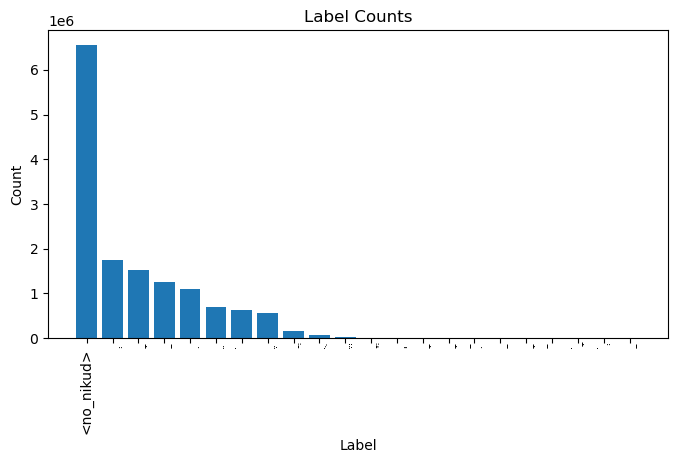

In [18]:
# Count the number of each label
label_count = {}
for label_list in tqdm(data_df['nikud']):
    # Flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
print(label_count)

# Plot counts of each label (sorted)
sorted_labels = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_labels)
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.bar([x[0] for x in sorted_labels], [x[1] for x in sorted_labels])
plt.show()

# label_names = []
# label_str = label_count.keys()
# # remove "<no_nikud>" from label_str
# label_str = [label for label in label_str if label != "<no_nikud>"]
# # each label in label str is of len >=1, convert each of those using nikud_dict
# for label in label_str:
#     label_name = []
#     for i in range(len(label)):
#         label_name.append(nikud_dict[label[i]])
#     label_names.append(' '.join(label_name))
# print(label_names)





def set_no_nikud_weights(weight=0.33):
    label_weights = {}
    for label in label_count:
        if label == "<no_nikud>":
            label_weights[label] = weight
        else:
            label_weights[label] = 1
    sum_weights = sum(label_weights.values())
    for label in label_weights:
        label_weights[label] /= sum_weights
    # sort labels by label_to_id
    label_weights = {k: v for k, v in sorted(label_weights.items(), key=lambda item: label_to_id[item[0]])}
    return label_weights


In [20]:
print(data_df.head())

                                     text_with_nikud   
0  פֶתַח דָבָר יִתְבָרֵךְ הַבוֹרֵא וְיִשְתַבַח הַ...  \
1                        וְלֵיהָנוֹת מִזִיו הַתוֹרָה   
2   וַאֲשֶר לֹא עָזַב חַסְדוֹ זֶה מִמֶנִי עַד הַיוֹם   
3  וְהִיא שֶעָמְדָה לִי לְחַדֵש חִידושִים בְעִנְי...   
4                             כְיָד ה הַטוֹבָה עָלַי   

                                  text_without_nikud   
0  פתח דבר יתברך הבורא וישתבח היוצר אשר מעודי גבר...  \
1                                 וליהנות מזיו התורה   
2                   ואשר לא עזב חסדו זה ממני עד היום   
3  והיא שעמדה לי לחדש חידושים בענינים שונים בשס ו...   
4                                    כיד ה הטובה עלי   

                                               nikud                   author   
0  [[ֶ, ַ, ], [ָ, ָ, ], [ִ, ְ, ָ, ֵ, ְ], [ַ, , ֹ,...  afikeiyam1__nikud_meteg  \
1    [[ְ, ֵ, , ָ, , ֹ, ], [ִ, ִ, , ], [ַ, , ֹ, ָ, ]]  afikeiyam1__nikud_meteg   
2  [[ַ, ֲ, ֶ, ], [ֹ, ], [ָ, ַ, ], [ַ, ְ, , ֹ], [ֶ...  afikeiyam1__nikud_meteg   
3 

### EDA - DataAnalysis on short_df

number of samples:  304205
each sample has the following columns:  Index(['text_with_nikud', 'text_without_nikud', 'nikud', 'author', 'file_name',
       'sentence_num'],
      dtype='object')


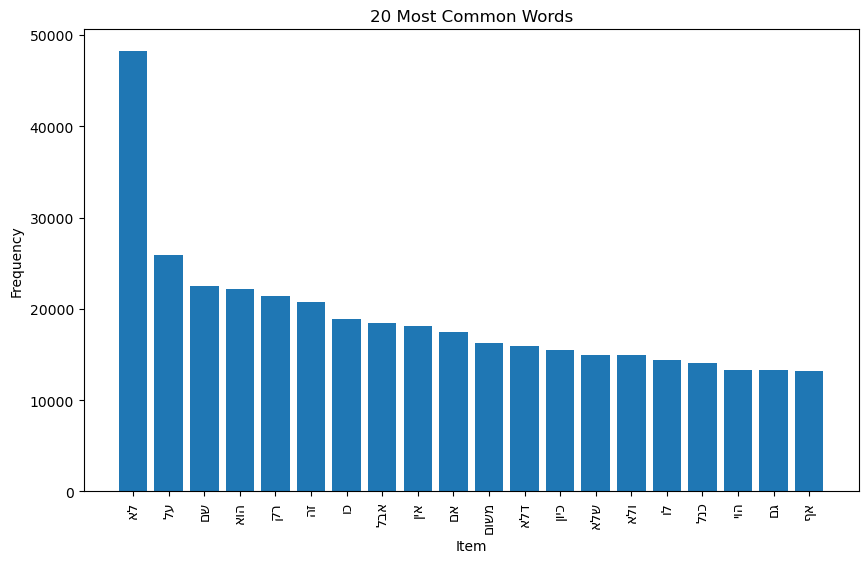

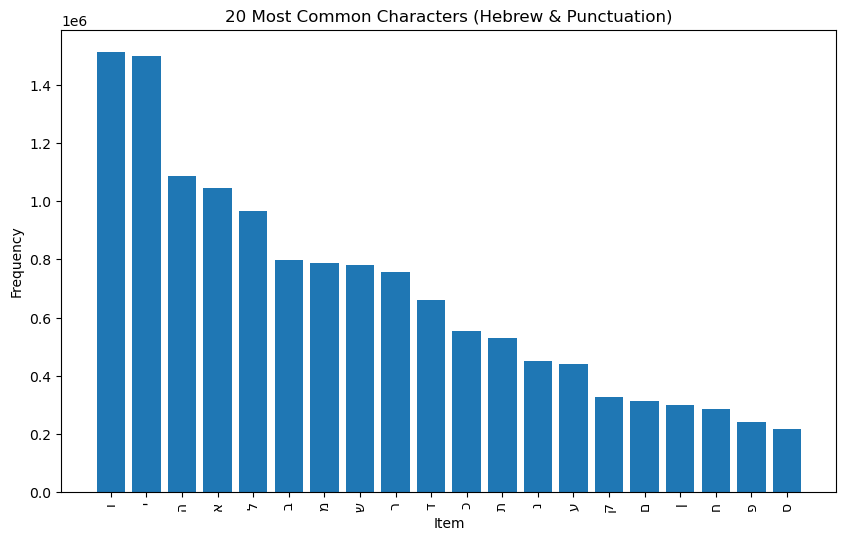

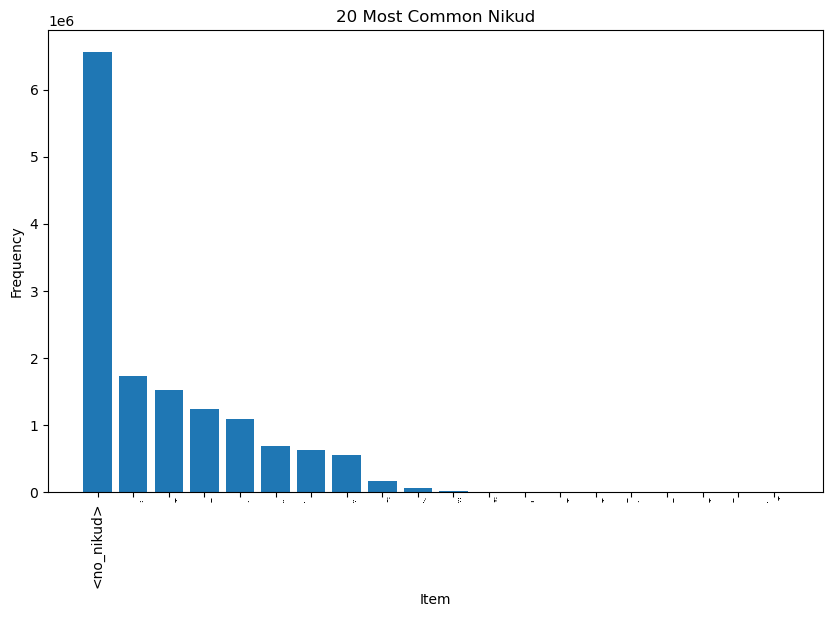

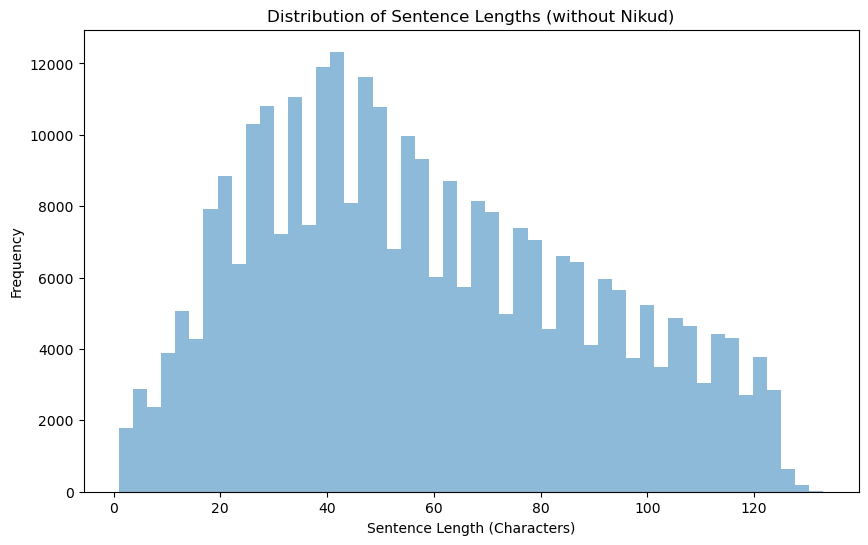

In [30]:
import matplotlib.pyplot as plt
from collections import Counter
import string

class DataAnalysis:
    def __init__(self, data_df):
        # Select only the relevant columns
        self.data_df = data_df[['nikud', 'text_without_nikud', 'text_with_nikud']].copy()
        
    def analyze_distribution(self, items, title):
        # Count the frequency of items
        item_counts = Counter(items)
        common_items = item_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common items
        plt.figure(figsize=(10, 6))
        items, counts = zip(*common_items)
        plt.bar(items, counts)
        plt.xlabel('Item')
        plt.ylabel('Frequency')
        plt.title(title)
        plt.xticks(rotation=90)
        plt.show()

    def common_words(self):
        # Tokenize the sentences without Nikud
        words = self.data_df['text_without_nikud'].str.split().explode().tolist()
        # reverse each word (hebrew is written from right to left)
        words = [word[::-1] for word in words]
        self.analyze_distribution(words, '20 Most Common Words')

    def common_characters(self):
        # Concatenate all texts without Nikud
        text = ''.join(self.data_df['text_without_nikud'])
        
        # Consider only Hebrew letters and punctuation
        characters = [char for char in text if char in string.punctuation or '\u0590' <= char <= '\u05FF']
        self.analyze_distribution(characters, '20 Most Common Characters (Hebrew & Punctuation)')

    def common_nikud(self):
        # Flatten the list of Nikud
        nikud = [item for sublist in self.data_df['nikud'] for innerlist in sublist for item in innerlist]
        # conver empty strings to '<no_nikud>'
        nikud = ['<no_nikud>' if nikud == '' else nikud for nikud in nikud]
        self.analyze_distribution(nikud, '20 Most Common Nikud')

    def sentence_length_distribution(self):
        # Histogram of the distribution of sentence lengths (without Nikud)
        sentence_lengths = self.data_df['text_without_nikud'].str.len()
        plt.figure(figsize=(10, 6))
        plt.hist(sentence_lengths, bins=50, alpha=0.5)
        plt.xlabel('Sentence Length (Characters)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Sentence Lengths (without Nikud)')
        plt.show()


# Instantiate the DataAnalysis class
data_analysis = DataAnalysis(data_df)
print("number of samples: ", len(data_df))
print("each sample has the following columns: ", data_df.columns)

# Call the methods to perform the analyses
data_analysis.common_words()                  # Analyzes the 20 most common words
data_analysis.common_characters()             # Analyzes the 20 most common Hebrew characters and punctuation
data_analysis.common_nikud()                  # Analyzes the 20 most common Nikud
data_analysis.sentence_length_distribution()  # Shows the distribution of sentence lengths


# download tokenizer (charachter level alephbert)

In [31]:
# this is charachter level alephbert, we manually deleted from the vocab all tokens that are more than one charachter long (including hebrew letters)
model_path = 'C:\\Users\\baruc\\PycharmProjects\\pythonProject\\Punctuation_Restoration\\AlephBERT-main\\AlephBERT-main\\models\\alephbert-base'
alephbert_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [32]:
# test the tokenization and detokenization
test = "בדיקה של הדבר הזה"
tokenized = alephbert_tokenizer.tokenize(test)
encoded = alephbert_tokenizer.encode(test)
decoded = alephbert_tokenizer.decode(encoded)
print(test)
print("tokenized: ", tokenized)
print("encoded: ", encoded)
print("decoded: ", decoded)

בדיקה של הדבר הזה
tokenized:  ['ב', '##ד', '##י', '##ק', '##ה', 'ש', '##ל', 'ה', '##ד', '##ב', '##ר', 'ה', '##ז', '##ה']
encoded:  [2, 177, 1039, 1008, 1013, 1016, 201, 1009, 180, 1039, 1037, 1014, 180, 1075, 1016, 3]
decoded:  [CLS] בדיקה של הדבר הזה [SEP]


## Check all data in the DataFrame is correct

In [33]:
data_df.iloc[0]
text = data_df.iloc[0]['text_without_nikud']
nikud = data_df.iloc[0]['nikud']
for row in data_df.iterrows():
    text = row[1]['text_without_nikud']
    text_with_nikud = row[1]['text_with_nikud']
    nikud = row[1]['nikud']
    text_words = text.split()
    sentence = []
    for i in range(len(nikud)):
        sentence.append(add_nikud(text_words[i], nikud[i]))
    sentence = ' '.join(sentence)
    if sentence != text_with_nikud:
        print(sentence)
        print(text_with_nikud)
        print('------------------')

# create DataSet class

In [34]:
# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))

class PunctuationRestorationDataset(Dataset):
    def __init__(self, data_df, tokenizer, label_to_id, max_len):
        self.data = data_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_to_id = label_to_id 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # TODO: need to make sure not to look at fraction of words
        text = self.data.iloc[index]['text_without_nikud']
        nikud = self.data.iloc[index]['nikud']  # list of lists of nikud

        # flatten nikud list
        nikud = [item for sublist in nikud for item in sublist]
        # replace empty strings with <no_nikud> token
        nikud = [label if label != "" else "<no_nikud>" for label in nikud]
        # replace labels with ids
        nikud = [self.label_to_id[label] for label in nikud]

        # check if nikud length is the same as text without spaces length
        if len(text.replace(" ", "")) != len(nikud):
            print("text without spaces length: ", len(text.replace(" ", "")))
            print("nikud length: ", len(nikud))
        
        # get word indices after tokenization
        word_indices = get_words_indices_from_text(text)
        # pad word_indices to be the same length as input_ids
        word_indices = word_indices + [(-1, -1)] * (self.max_len - len(word_indices))
        # convert word_indices to tensor
        word_indices = torch.tensor(word_indices, dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # pad nikud to be the same length as input_ids
        nikud = nikud + [len(label_to_id)] * (encoding['input_ids'].shape[1] - len(nikud))
        # convert to tensor
        nikud = torch.tensor(nikud, dtype=torch.long)
        
        return {
            'text': text,
            'nikud': nikud,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'word_indices': word_indices
        }


# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))
dataset = PunctuationRestorationDataset(data_df, alephbert_tokenizer, label_to_id, 100)
print("dataset length: ", len(dataset))

dataset length:  304205


## Split to train,val and test torch datasets and dataloaders

In [35]:
# split dataset to train, val and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print basic info about datasets and dataloaders

In [42]:
# print dataset size
print("train dataset size: ", len(train_dataset))
print("val dataset size: ", len(val_dataset))
print("test dataset size: ", len(test_dataset))

# print dataloader size (data size / batch size)
print("batch size: ", batch_size)
print("train_loader size: ", len(train_loader))
print("val_loader size: ", len(val_loader))
print("test_loader size: ", len(test_loader))

# print sample type and keys
print("train dataset[0] type: ", type(train_dataset[0]))
print("train dataset[0] keys: ", train_dataset[0].keys())

train dataset size:  194691
val dataset size:  48673
test dataset size:  60841
batch size:  32
train_loader size:  6085
val_loader size:  1522
test_loader size:  1902
train dataset[0] type:  <class 'dict'>
train dataset[0] keys:  dict_keys(['text', 'nikud', 'input_ids', 'attention_mask', 'word_indices'])


# Define the two models (one with look-ahead, one without)

### train the two models

### Evaluate the models

## Full-Sentence Model

In [43]:
class FullSentenceModel(nn.Module):
    def __init__(self, char_vocab_size, num_labels, char_embedding_dim=32, word_hidden_dim=16, char_hidden_dim=512, num_layers=4):
        super(FullSentenceModel, self).__init__()
        
        self.word_hidden_dim = word_hidden_dim
        
        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        
        # Word-Level BiLSTM
        self.word_bilstm = nn.LSTM(char_embedding_dim, word_hidden_dim, bidirectional=True, batch_first=True)
        
        # Character-Level LSTM
        self.char_lstm = nn.LSTM(input_size=char_embedding_dim + 2 * word_hidden_dim, hidden_size=char_hidden_dim,bidirectional=True, batch_first=True, num_layers=num_layers)
        
        # Fully Connected Layer
        self.fc = nn.Linear(2 * char_hidden_dim, num_labels)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_sequence, word_boundaries):
        # Apply Character Embedding
        char_embedded = self.char_embedding(char_sequence)
        
        # Process each word using the Word-Level BiLSTM
        word_embeddings_list = []
        for i in range(len(char_sequence)):
            word_embedding_for_sample = []
            for boundaries in word_boundaries[i]:
                start, end = boundaries
                if start == -1:
                    break
                word_seq = char_embedded[i, start:end+1, :]
                word_seq_output, _ = self.word_bilstm(word_seq.unsqueeze(0))
                word_embedding = torch.cat((word_seq_output[0, -1, :self.word_hidden_dim], 
                                            word_seq_output[0, 0, self.word_hidden_dim:]), dim=0)
                word_embedding_for_sample.append(word_embedding)
            word_embeddings_list.append(torch.stack(word_embedding_for_sample))
        
        # Pad the word embeddings to the same length as the input sequence
        max_length = char_embedded.size(1)
        padded_word_embeddings_list = []
        for embed in word_embeddings_list:
            padding_length = max_length - embed.size(0)
            padding = torch.zeros(padding_length, embed.size(1)).to(embed.device)
            padded_embed = torch.cat([embed, padding], dim=0)
            padded_word_embeddings_list.append(padded_embed)
        word_embeddings_tensor = torch.stack(padded_word_embeddings_list, dim=0)
        
        # Concatenate the character embeddings with the word embeddings
        char_word_embedded = torch.cat([char_embedded, word_embeddings_tensor], dim=2)
        
        # Apply Character-Level LSTM
        char_lstm_output, _ = self.char_lstm(char_word_embedded)
        
        # Apply Dropout
        char_lstm_output = self.dropout(char_lstm_output)
        
        # Apply Fully Connected Layer
        predictions = self.fc(char_lstm_output)
        
        return predictions
    



FullSentenceModel train and evaluate

In [44]:
def train_full_sentence_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        word_indices = batch['word_indices'].to(device)
        labels = batch['nikud'].to(device)
        optimizer.zero_grad()
        predictions = model.forward(input_ids, word_indices)
        loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        attention_mask = batch['attention_mask']
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        predictions = torch.argmax(predictions, dim=1)

        # calculate accuracy
        pre = predictions.cpu().numpy()
        lab = labels.cpu().numpy()
        total_correct += np.sum(pre == lab)
        total_overall += len(pre)
        
    accuracy_avg = total_correct / total_overall
    loss_avg = total_loss / len(train_loader)
    return loss_avg, accuracy_avg

# Define evaluate method
def evaluate_full_sentence_model(model, eval_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            input_ids = batch['input_ids'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids, word_indices)
            loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
            total_loss += loss.item()
            # total_correct += (predictions.argmax(2) == labels).sum().item()

            attention_mask = batch['attention_mask']
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            predictions = predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            predictions = torch.argmax(predictions, dim=1)
            # calculate accuracy
            pre = predictions.cpu().numpy()
            lab = labels.cpu().numpy()
            total_correct += np.sum(pre == lab)
            total_overall += len(pre)
    accuracy_avg = total_correct / total_overall
    loss_avg = total_loss / len(train_loader)
    return loss_avg, accuracy_avg




FullSentenceModel predict

In [45]:
# Define predict method
def predict_full_sentence_model(model, test_loader):
    """
    Predict the labels of the test set using the model.
    """
    model.eval()
    actual_labels = []
    predictions = []
    all_words = []
    for batch in tqdm(test_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            
            # get the model's predictions
            batch_predictions = model.forward(input_ids, word_indices)
            batch_predictions = batch_predictions.view(-1, batch_predictions.shape[-1])
            labels = labels.view(-1)
            word_indices = word_indices.view(-1, 2)
            
            # remove the padding tokens from the predictions
            batch_predictions = batch_predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            word_indices = word_indices[word_indices[:, 0] != -1]
            
            # get the top 2 predictions for each token
            batch_predictions = torch.topk(batch_predictions, k=2, dim=1).indices
            first_prediction = batch_predictions[:, 0]
            second_prediction = batch_predictions[:, 1]
            
            predictions.extend(first_prediction)
            actual_labels.extend(labels)
            all_words.extend(word_indices)
    all_words = [word.tolist() for word in all_words]
    all_words = list(map(lambda x: x[1]-x[0]+1, all_words))
    return actual_labels, predictions, all_words

FullSentenceModel main model - define model train and save it

In [46]:
# Hyperparameters
char_vocab_size = alephbert_tokenizer.vocab_size
char_embedding_dim = 32
word_hidden_dim = 16
char_hidden_dim = 512
num_labels = len(label_to_id)
num_epochs = 10
learning_rate = 0.001
no_nikud_weight = 1

# Model, Criterion, Optimizer
full_sentence_model = FullSentenceModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
label_weights = set_no_nikud_weights(no_nikud_weight)
weights = torch.tensor(list(label_weights.values())).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)
optimizer = optim.Adam(full_sentence_model.parameters(), lr=learning_rate)

# History
train_full_sentence_model_loss_history = []
val_full_sentence_model_loss_history = []
train_full_sentence_model_accuracy_history = []
val_full_sentence_model_accuracy_history = []

for epoch in range(num_epochs):
    if os.path.exists(f'full-sentence-final-models/full_model_{epoch+1}_epoch.pt'):
        # load model
        full_sentence_model.load_state_dict(torch.load(f'full-sentence-final-models/full_model_{epoch+1}_epoch.pt'))
        print(f'Model {epoch+1} loaded successfully!')
        # load loss history
        with open(f'full-sentence-final-models/full_model_{epoch+1}_epoch_loss_history.pkl', 'rb') as f:
            train_full_sentence_model_loss_history, val_full_sentence_model_loss_history = pickle.load(f)
        print(f'Model {epoch+1} loss history loaded successfully!')
        # load accuracy history
        with open(f'full-sentence-final-models/full_model_{epoch+1}_epoch_accuracy_history.pkl', 'rb') as f:
            train_full_sentence_model_accuracy_history, val_full_sentence_model_accuracy_history = pickle.load(f)
        print(f'Model {epoch+1} accuracy history loaded successfully!')
        continue
    else:
        train_loss, train_accuracy = train_full_sentence_model(full_sentence_model, train_loader, optimizer, criterion)
        eval_loss, eval_accuracy = evaluate_full_sentence_model(full_sentence_model, val_loader, criterion)
        train_full_sentence_model_loss_history.append(train_loss)
        val_full_sentence_model_loss_history.append(eval_loss)
        train_full_sentence_model_accuracy_history.append(train_accuracy)
        val_full_sentence_model_accuracy_history.append(eval_accuracy)
        # save the model in "full-sentence-final-models" folder
        torch.save(full_sentence_model.state_dict(), f'full-sentence-final-models/full_model_{epoch+1}_epoch.pt')
        # save loss and accuracy history
        with open(f'full-sentence-final-models/full_model_{epoch+1}_epoch_loss_history.pkl', 'wb') as f:
            pickle.dump([train_full_sentence_model_loss_history, val_full_sentence_model_loss_history], f)
        # save accuracy history
        with open(f'full-sentence-final-models/full_model_{epoch+1}_epoch_accuracy_history.pkl', 'wb') as f:
            pickle.dump([train_full_sentence_model_accuracy_history, val_full_sentence_model_accuracy_history], f)
        print(f'Model {epoch+1} saved successfully!')
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
        print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
        print('-'*10)


Model 1 loaded successfully!
Model 1 loss history loaded successfully!
Model 1 accuracy history loaded successfully!
Model 2 loaded successfully!
Model 2 loss history loaded successfully!
Model 2 accuracy history loaded successfully!
Model 3 loaded successfully!
Model 3 loss history loaded successfully!
Model 3 accuracy history loaded successfully!
Model 4 loaded successfully!
Model 4 loss history loaded successfully!
Model 4 accuracy history loaded successfully!
Model 5 loaded successfully!
Model 5 loss history loaded successfully!
Model 5 accuracy history loaded successfully!
Model 6 loaded successfully!
Model 6 loss history loaded successfully!
Model 6 accuracy history loaded successfully!
Model 7 loaded successfully!
Model 7 loss history loaded successfully!
Model 7 accuracy history loaded successfully!
Model 8 loaded successfully!
Model 8 loss history loaded successfully!
Model 8 accuracy history loaded successfully!
Model 9 loaded successfully!
Model 9 loss history loaded success

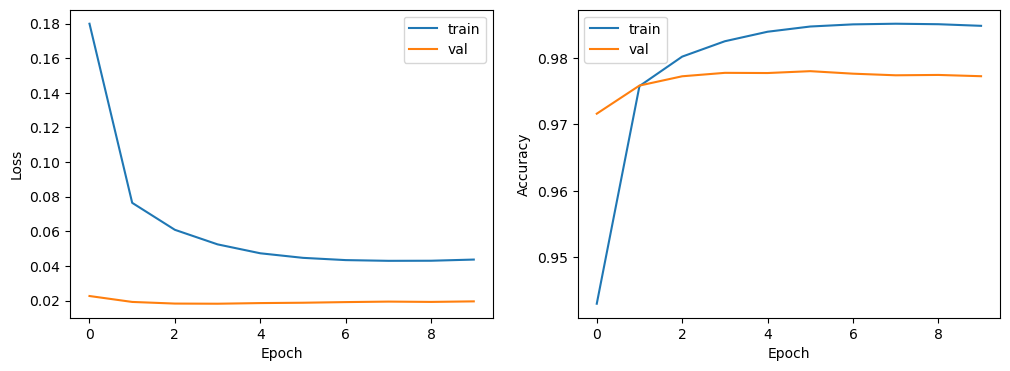

In [47]:
# plot loss and accuracy history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_full_sentence_model_loss_history, label='train')
plt.plot(val_full_sentence_model_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_full_sentence_model_accuracy_history, label='train')
plt.plot(val_full_sentence_model_accuracy_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




# Reading-Direction Model

In [48]:
class ReadingDirectionModel(nn.Module):
    def __init__(self, char_vocab_size, num_labels, char_embedding_dim=32, word_hidden_dim=16, char_hidden_dim=512, num_layers=4):
        super(ReadingDirectionModel, self).__init__()
        
        self.word_hidden_dim = word_hidden_dim
        
        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        
        # Word-Level BiLSTM
        self.word_bilstm = nn.LSTM(char_embedding_dim, word_hidden_dim, bidirectional=True, batch_first=True)
        
        # Character-Level LSTM
        self.char_lstm = nn.LSTM(input_size=char_embedding_dim + 2 * word_hidden_dim, hidden_size=char_hidden_dim, batch_first=True, num_layers=num_layers)
        
        # Fully Connected Layer
        self.fc = nn.Linear(char_hidden_dim, num_labels)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_sequence, word_boundaries):
        # Apply Character Embedding
        char_embedded = self.char_embedding(char_sequence)
        
        # Process each word using the Word-Level BiLSTM
        word_embeddings_list = []
        for i in range(len(char_sequence)):
            word_embedding_for_sample = []
            for boundaries in word_boundaries[i]:
                start, end = boundaries
                if start == -1:
                    break
                word_seq = char_embedded[i, start:end+1, :]
                word_seq_output, _ = self.word_bilstm(word_seq.unsqueeze(0))
                word_embedding = torch.cat((word_seq_output[0, -1, :self.word_hidden_dim], 
                                            word_seq_output[0, 0, self.word_hidden_dim:]), dim=0)
                word_embedding_for_sample.append(word_embedding)
            word_embeddings_list.append(torch.stack(word_embedding_for_sample))
        
        # Pad the word embeddings to the same length as the input sequence
        max_length = char_embedded.size(1)
        padded_word_embeddings_list = []
        for embed in word_embeddings_list:
            padding_length = max_length - embed.size(0)
            padding = torch.zeros(padding_length, embed.size(1)).to(embed.device)
            padded_embed = torch.cat([embed, padding], dim=0)
            padded_word_embeddings_list.append(padded_embed)
        word_embeddings_tensor = torch.stack(padded_word_embeddings_list, dim=0)
        
        # Concatenate the character embeddings with the word embeddings
        char_word_embedded = torch.cat([char_embedded, word_embeddings_tensor], dim=2)
        
        # Apply Character-Level LSTM
        char_lstm_output, _ = self.char_lstm(char_word_embedded)
        
        # Apply Dropout
        char_lstm_output = self.dropout(char_lstm_output)
        
        # Apply Fully Connected Layer
        predictions = self.fc(char_lstm_output)
        
        return predictions
    



Reading-Direction train and evaluate methods

In [49]:
def train_directional_model(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        word_indices = batch['word_indices'].to(device)
        labels = batch['nikud'].to(device)
        optimizer.zero_grad()
        predictions = model.forward(input_ids, word_indices)
        loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        attention_mask = batch['attention_mask']
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        predictions = torch.argmax(predictions, dim=1)

        # calculate accuracy
        pre = predictions.cpu().numpy()
        lab = labels.cpu().numpy()
        total_correct += np.sum(pre == lab)
        total_overall += len(pre)
    accuracy_avg = total_correct / total_overall
    loss_avg = total_loss / len(train_loader)
    return loss_avg, accuracy_avg

# Define evaluate method
def evaluate_directional_model(model, eval_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_overall = 0
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            input_ids = batch['input_ids'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids, word_indices)
            loss = criterion(predictions.view(-1, predictions.shape[-1]), labels.view(-1))
            total_loss += loss.item()

            attention_mask = batch['attention_mask']
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            predictions = predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            predictions = torch.argmax(predictions, dim=1)
            # calculate accuracy
            pre = predictions.cpu().numpy()
            lab = labels.cpu().numpy()
            total_correct += np.sum(pre == lab)
            total_overall += len(pre)
    accuracy_avg = total_correct / total_overall
    loss_avg = total_loss / len(eval_loader)
    return loss_avg, accuracy_avg



Reading-Direction predict method

In [50]:
# Define predict method
def predict_directional_model(model, test_loader):
    """
    Predict the labels of the test set using the model.
    """
    model.eval()
    actual_labels = []
    predictions = []
    all_words = []
    for batch in tqdm(test_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            
            # get the model's predictions
            batch_predictions = model.forward(input_ids, word_indices)
            batch_predictions = batch_predictions.view(-1, batch_predictions.shape[-1])
            labels = labels.view(-1)
            word_indices = word_indices.view(-1, 2)
            
            # remove the padding tokens from the predictions
            batch_predictions = batch_predictions[attention_mask.view(-1) == 1]
            labels = labels[attention_mask.view(-1) == 1]
            word_indices = word_indices[word_indices[:, 0] != -1]
            
            # get the top 2 predictions for each token
            batch_predictions = torch.topk(batch_predictions, k=2, dim=1).indices
            first_prediction = batch_predictions[:, 0]
            second_prediction = batch_predictions[:, 1]
            
            predictions.extend(first_prediction)
            actual_labels.extend(labels)
            all_words.extend(word_indices)
    all_words = [word.tolist() for word in all_words]
    all_words = list(map(lambda x: x[1]-x[0]+1, all_words))
    return actual_labels, predictions, all_words

Reading-Direction train model

In [51]:
# Hyperparameters
char_vocab_size = alephbert_tokenizer.vocab_size
char_embedding_dim = 64
word_hidden_dim = 32
char_hidden_dim = 512
num_labels = len(label_to_id)
num_epochs = 8
learning_rate = 0.001
no_nikud_weight = 1



# Model, Criterion, Optimizer
reading_direction_model = ReadingDirectionModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
label_weights = set_no_nikud_weights(no_nikud_weight)
weights = torch.tensor(list(label_weights.values())).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)
optimizer = optim.Adam(reading_direction_model.parameters(), lr=learning_rate)

# History
train_directional_model_loss_history = []
val_directional_model_loss_history = []
train_directional_model_accuracy_history = []
val_directional_model_accuracy_history = []

for epoch in range(num_epochs):
    # if there is a model saved in "reading-direction-final-models" folder, load it
    if os.path.exists(f'reading-direction-final-models/directional_model_{epoch+1}_epoch.pt'):
        reading_direction_model.load_state_dict(torch.load(f'reading-direction-final-models/directional_model_{epoch+1}_epoch.pt'))
        print(f'Model {epoch+1} loaded successfully!')
        with open(f'reading-direction-final-models/directional_model_{epoch+1}_epoch_loss_history.pkl', 'rb') as f:
            train_directional_model_loss_history, val_directional_model_loss_history = pickle.load(f)
        print(f'Model {epoch+1} loss history loaded successfully!')
        with open(f'reading-direction-final-models/directional_model_{epoch+1}_epoch_accuracy_history.pkl', 'rb') as f:
            train_directional_model_accuracy_history, val_directional_model_accuracy_history = pickle.load(f)
        print(f'Model {epoch+1} accuracy history loaded successfully!')
        continue
    else:
        train_loss, train_accuracy = train_directional_model(reading_direction_model, train_loader, optimizer, criterion)
        eval_loss, eval_accuracy = evaluate_directional_model(reading_direction_model, val_loader, criterion)
        train_directional_model_loss_history.append(train_loss)
        val_directional_model_loss_history.append(eval_loss)
        train_directional_model_accuracy_history.append(train_accuracy)
        val_directional_model_accuracy_history.append(eval_accuracy)
        # save the model in "reading-direction-final-models" folder
        torch.save(reading_direction_model.state_dict(), f'reading-direction-final-models/directional_model_{epoch+1}_epoch.pt')
        # save loss and accuracy history
        with open(f'reading-direction-final-models/directional_model_{epoch+1}_epoch_loss_history.pkl', 'wb') as f:
            pickle.dump([train_directional_model_loss_history, val_directional_model_loss_history], f)
        # save accuracy history
        with open(f'reading-direction-final-models/directional_model_{epoch+1}_epoch_accuracy_history.pkl', 'wb') as f:
            pickle.dump([train_directional_model_accuracy_history, val_directional_model_accuracy_history], f)
        print(f'Model {epoch+1} saved successfully!')
        print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
        print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
        print('-'*10)

Model 1 loaded successfully!
Model 1 loss history loaded successfully!
Model 1 accuracy history loaded successfully!
Model 2 loaded successfully!
Model 2 loss history loaded successfully!
Model 2 accuracy history loaded successfully!
Model 3 loaded successfully!
Model 3 loss history loaded successfully!
Model 3 accuracy history loaded successfully!
Model 4 loaded successfully!
Model 4 loss history loaded successfully!
Model 4 accuracy history loaded successfully!
Model 5 loaded successfully!
Model 5 loss history loaded successfully!
Model 5 accuracy history loaded successfully!
Model 6 loaded successfully!
Model 6 loss history loaded successfully!
Model 6 accuracy history loaded successfully!
Model 7 loaded successfully!
Model 7 loss history loaded successfully!
Model 7 accuracy history loaded successfully!
Model 8 loaded successfully!
Model 8 loss history loaded successfully!
Model 8 accuracy history loaded successfully!


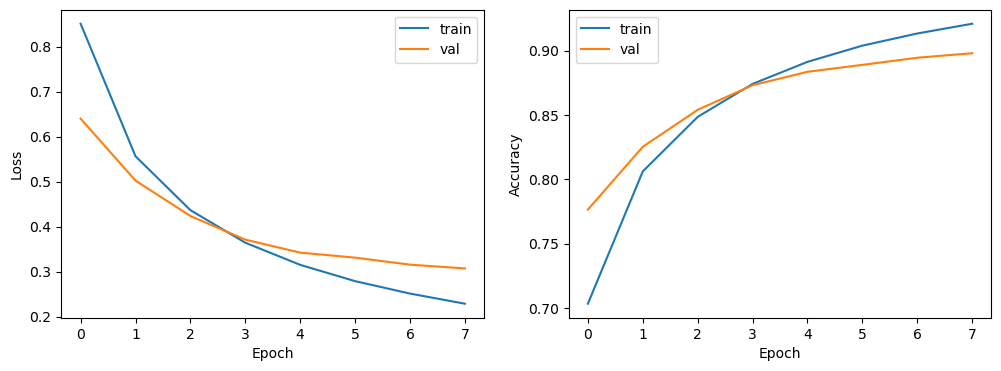

In [52]:
# plot loss and accuracy history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_directional_model_loss_history, label='train')
plt.plot(val_directional_model_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_directional_model_accuracy_history, label='train')
plt.plot(val_directional_model_accuracy_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Models greed search hyperparameters tuning

### Full sentence model greed search hyperparameters

In [53]:
# constansts for the model
num_labels = len(label_to_id)
char_vocab_size = alephbert_tokenizer.vocab_size

# Do grid search on the following hyperparameters
word_and_char_embedding_dim = [(16,32), (32,64), (64, 128)]
char_hidden_dims = [512, 1024]
learning_rate = [0.001, 0.0001]
weights_for_no_nikud = [1, 0.5]
num_epochs = 20

# TODO: change word_hidden_dim to word_embedding_dim
for word_hidden_dim, char_embedding_dim in word_and_char_embedding_dim:
    for char_hidden_dim in char_hidden_dims:
        for weight in weights_for_no_nikud:
            for learn_rate in learning_rate:
                if os.path.exists(f'./models/f_s_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl'):
                    print(f'./models/f_s_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl exists')
                    continue
                print("Training model for char_embedding_dim={}, char_hidden_dim={}, weight={}, learn_rate={}".format(char_embedding_dim, char_hidden_dim, weight, learn_rate))
                label_weights = set_no_nikud_weights(weight)
                weights = torch.tensor(list(label_weights.values())).to(device)
                # Create the model
                
                full_sentence_model = FullSentenceModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
                criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)
                optimizer = optim.Adam(full_sentence_model.parameters(), lr=learn_rate)
                train_full_sentence_model_loss_history = []
                val_full_sentence_model_loss_history = []
                train_full_sentence_model_accuracy_history = []
                val_full_sentence_model_accuracy_history = []
                for epoch in range(num_epochs):
                    train_loss, train_accuracy = train_directional_model(full_sentence_model, train_loader, optimizer, criterion)
                    eval_loss, eval_accuracy = evaluate_directional_model(full_sentence_model, val_loader, criterion)
                    train_full_sentence_model_loss_history.append(train_loss)
                    val_full_sentence_model_loss_history.append(eval_loss)
                    train_full_sentence_model_accuracy_history.append(train_accuracy)
                    val_full_sentence_model_accuracy_history.append(eval_accuracy)
                    print(f'Epoch: {epoch+1}, for {char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}')
                    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
                    print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
                    print('-'*10)
                    if epoch in [4, 9, 14, 19]:
                        torch.save(full_sentence_model.state_dict(), f'./models/f_s_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}_{epoch+1}.pt')
                        print(f'./models/f_s_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}_{epoch+1}.pt saved')
                        print('-'*10)
                with open(f'./models/f_s_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl', 'wb') as f:
                    pickle.dump([train_full_sentence_model_loss_history, val_full_sentence_model_loss_history, train_full_sentence_model_accuracy_history, val_full_sentence_model_accuracy_history], f)
                print(f'./models/f_s_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl saved')
                # plot loss and accuracy history
                print("Plotting loss and accuracy history for char_embedding_dim={}, char_hidden_dim={}, weight={}, learn_rate={}".format(char_embedding_dim, char_hidden_dim, weight, learn_rate))
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(train_full_sentence_model_loss_history, label='train')
                plt.plot(val_full_sentence_model_loss_history, label='val')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.subplot(1, 2, 2)
                plt.plot(train_full_sentence_model_accuracy_history, label='train')
                plt.plot(val_full_sentence_model_accuracy_history, label='val')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.show()

./models/f_s_32_512_1_0.001.pkl exists
./models/f_s_32_512_1_0.0001.pkl exists
./models/f_s_32_512_0.5_0.001.pkl exists
./models/f_s_32_512_0.5_0.0001.pkl exists
./models/f_s_32_1024_1_0.001.pkl exists
./models/f_s_32_1024_1_0.0001.pkl exists
./models/f_s_32_1024_0.5_0.001.pkl exists
./models/f_s_32_1024_0.5_0.0001.pkl exists
./models/f_s_64_512_1_0.001.pkl exists
./models/f_s_64_512_1_0.0001.pkl exists
./models/f_s_64_512_0.5_0.001.pkl exists
./models/f_s_64_512_0.5_0.0001.pkl exists
./models/f_s_64_1024_1_0.001.pkl exists
./models/f_s_64_1024_1_0.0001.pkl exists
./models/f_s_64_1024_0.5_0.001.pkl exists
./models/f_s_64_1024_0.5_0.0001.pkl exists
./models/f_s_128_512_1_0.001.pkl exists
./models/f_s_128_512_1_0.0001.pkl exists
./models/f_s_128_512_0.5_0.001.pkl exists
./models/f_s_128_512_0.5_0.0001.pkl exists
./models/f_s_128_1024_1_0.001.pkl exists
./models/f_s_128_1024_1_0.0001.pkl exists
./models/f_s_128_1024_0.5_0.001.pkl exists
./models/f_s_128_1024_0.5_0.0001.pkl exists


### Reading-Direction greed search hyperparameters

In [54]:
# constansts for the model
num_labels = len(label_to_id)
char_vocab_size = alephbert_tokenizer.vocab_size

# Do grid search on the following hyperparameters
word_and_char_embedding_dim = [(16,32), (32,64), (64, 128)]
char_hidden_dims = [512, 1024]
learning_rate = [0.001, 0.0001]
weights_for_no_nikud = [1, 0.5]
num_epochs = 20


for word_hidden_dim, char_embedding_dim in word_and_char_embedding_dim:
    for char_hidden_dim in char_hidden_dims:
        for weight in weights_for_no_nikud:
            for learn_rate in learning_rate:
                if os.path.exists(f'./models/r_d_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl'):
                    print(f'./models/r_d_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl exists')
                    continue
                label_weights = set_no_nikud_weights(weight)
                weights = torch.tensor(list(label_weights.values())).to(device)
                # Create the model
                reading_direction_model = ReadingDirectionModel(char_vocab_size, num_labels, char_embedding_dim=char_embedding_dim, word_hidden_dim=word_hidden_dim, char_hidden_dim=char_hidden_dim).to(device)
                criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)
                optimizer = optim.Adam(reading_direction_model.parameters(), lr=learn_rate)
                train_directional_model_loss_history = []
                val_directional_model_loss_history = []
                train_directional_model_accuracy_history = []
                val_directional_model_accuracy_history = []
                for epoch in range(num_epochs):
                    train_loss, train_accuracy = train_directional_model(reading_direction_model, train_loader, optimizer, criterion)
                    eval_loss, eval_accuracy = evaluate_directional_model(reading_direction_model, val_loader, criterion)
                    train_directional_model_loss_history.append(train_loss)
                    val_directional_model_loss_history.append(eval_loss)
                    train_directional_model_accuracy_history.append(train_accuracy)
                    val_directional_model_accuracy_history.append(eval_accuracy)
                    print(f'Epoch: {epoch+1}, for {char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}')
                    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
                    print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
                    print('-'*10)
                    if epoch in [4, 9, 14, 19]:
                        torch.save(reading_direction_model.state_dict(), f'./models/r_d_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}_{epoch+1}.pt')
                        print(f'./models/r_d_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}_{epoch+1}.pt saved')
                        print('-'*10)
                with open(f'./models/r_d_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl', 'wb') as f:
                    pickle.dump([train_directional_model_loss_history, val_directional_model_loss_history, train_directional_model_accuracy_history, val_directional_model_accuracy_history], f)
                print(f'./models/r_d_{char_embedding_dim}_{char_hidden_dim}_{weight}_{learn_rate}.pkl saved')
                # plot loss and accuracy history
                print("Plotting loss and accuracy history for char_embedding_dim={}, char_hidden_dim={}, weight={}, learn_rate={}".format(char_embedding_dim, char_hidden_dim, weight, learn_rate))
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(train_directional_model_loss_history, label='train')
                plt.plot(val_directional_model_loss_history, label='val')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.subplot(1, 2, 2)
                plt.plot(train_directional_model_accuracy_history, label='train')
                plt.plot(val_directional_model_accuracy_history, label='val')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.show()





./models/r_d_32_512_1_0.001.pkl exists
./models/r_d_32_512_1_0.0001.pkl exists
./models/r_d_32_512_0.5_0.001.pkl exists
./models/r_d_32_512_0.5_0.0001.pkl exists
./models/r_d_32_1024_1_0.001.pkl exists
./models/r_d_32_1024_1_0.0001.pkl exists
./models/r_d_32_1024_0.5_0.001.pkl exists
./models/r_d_32_1024_0.5_0.0001.pkl exists
./models/r_d_64_512_1_0.001.pkl exists
./models/r_d_64_512_1_0.0001.pkl exists
./models/r_d_64_512_0.5_0.001.pkl exists
./models/r_d_64_512_0.5_0.0001.pkl exists
./models/r_d_64_1024_1_0.001.pkl exists
./models/r_d_64_1024_1_0.0001.pkl exists
./models/r_d_64_1024_0.5_0.001.pkl exists
./models/r_d_64_1024_0.5_0.0001.pkl exists
./models/r_d_128_512_1_0.001.pkl exists
./models/r_d_128_512_1_0.0001.pkl exists
./models/r_d_128_512_0.5_0.001.pkl exists
./models/r_d_128_512_0.5_0.0001.pkl exists
./models/r_d_128_1024_1_0.001.pkl exists
./models/r_d_128_1024_1_0.0001.pkl exists
./models/r_d_128_1024_0.5_0.001.pkl exists
./models/r_d_128_1024_0.5_0.0001.pkl exists


### Choosing hyperparameters both for full_sentence and reading_direction
load all the loss and accuracy history calculated in the hyperparameter grid search and plot them together for comparison

In [67]:
def load_history(model_parameters, path_template, skip=False):
    train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = [], [], [], []
    for params in model_parameters:
        index = 0
        file_path = path_template.format(*params)
        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                if skip and index < -8:
                    check = pickle.load(f)
                    train_loss, val_loss = check[0], check[1]
                    train_accuracy, val_accuracy = 0, 0
                else:
                    train_loss, val_loss, train_accuracy, val_accuracy = pickle.load(f)
                train_loss_history.append(train_loss)
                val_loss_history.append(val_loss)
                train_accuracy_history.append(train_accuracy)
                val_accuracy_history.append(val_accuracy)
                # print(f'{file_path} loaded')
                index += 1
        else:
            print(f'{file_path} does not exist')
        # print('-'*10)
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

def plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy, labels):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for t_loss, v_loss, label in zip(train_loss, val_loss, labels):
        plt.plot(t_loss, label=f'train_{label}')
        plt.plot(v_loss, label=f'val_{label}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    for t_acc, v_acc, label in zip(train_accuracy, val_accuracy, labels):
        plt.plot(t_acc, label=f'train_{label}')
        plt.plot(v_acc, label=f'val_{label}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def find_best_model(model_parameters, path_template):
    best_model_params, best_epoch, best_val_accuracy = None, None, 0
    for params in model_parameters:
        file_path = path_template.format(*params)
        # print(f'Checking {file_path}')
        if os.path.exists(file_path):
            with open(file_path, 'rb') as f:
                _, _, _, val_accuracy = pickle.load(f)
                best_local_val_accuracy = max(val_accuracy)
                index = val_accuracy.index(best_local_val_accuracy)
                for acc in val_accuracy:
                    if acc > best_val_accuracy:
                        best_val_accuracy = acc
                        best_epoch = val_accuracy.index(acc) + 1
                        best_model_params = params
            # print(f'Current params: {params}\tbest local val accuracy: {best_local_val_accuracy.round(4)} at epoch {index + 1}')
            # print('-'*10)
        else:
            print(f'{file_path} does not exist')
            print('-'*10)
    return best_model_params, best_epoch, best_val_accuracy






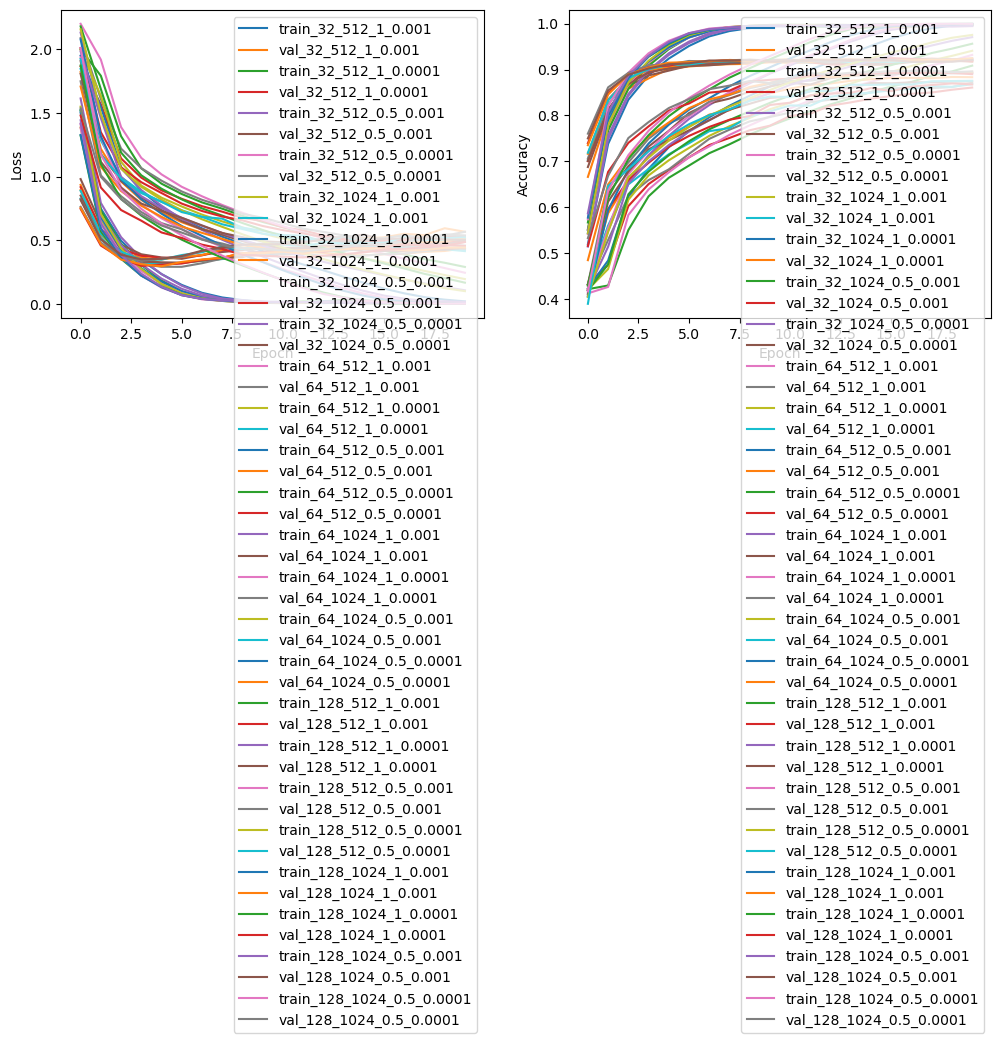

Best full sentence model: (128, 512, 1, 0.001)
Best full sentence model epoch: 16
Best full sentence model val accuracy: 0.9249386542683714
----------


In [68]:
model_parameters = [(c, ch, wt, lr) for w, c in word_and_char_embedding_dim for ch in char_hidden_dims for wt in weights_for_no_nikud for lr in learning_rate]
# plot and find best model for Full Sentence model
path_template = './models/f_s_{}_{}_{}_{}.pkl'
# load history
train_loss, val_loss, train_accuracy, val_accuracy = load_history(model_parameters, path_template)
# plot loss and accuracy
plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy, [f'{p[0]}_{p[1]}_{p[2]}_{p[3]}' for p in model_parameters])
# find best Full Sentence model
best_model, best_epoch, best_val_accuracy = find_best_model(model_parameters, path_template)
# print best Full Sentence model
print(f'Best full sentence model: {best_model}')
print(f'Best full sentence model epoch: {best_epoch}')
print(f'Best full sentence model val accuracy: {best_val_accuracy}')
print('-'*10)

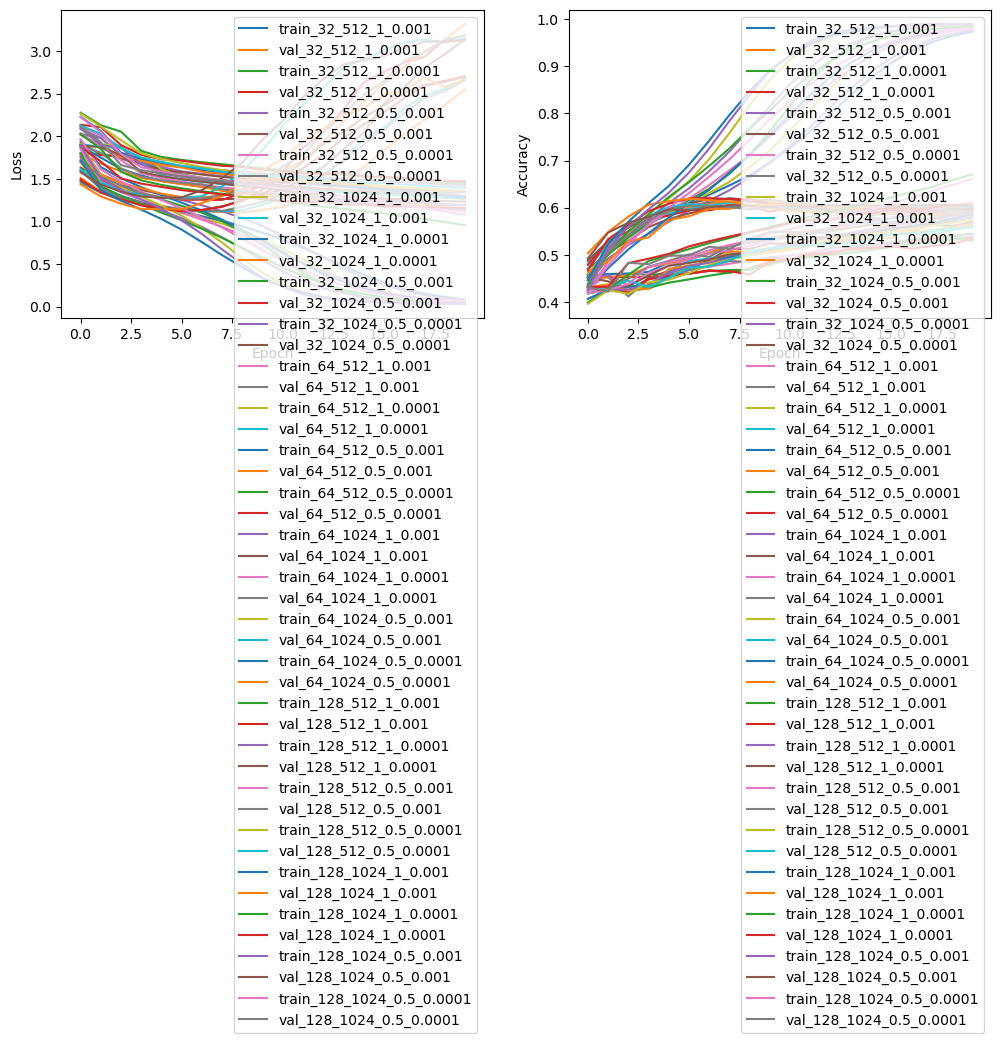

Best Reading Direction model: (64, 512, 1, 0.001)
Best Reading Direction model epoch: 8
Best Reading Direction model val accuracy: 0.6208962934263206


In [69]:
# plot and find best model for Reading Direction model
path_template = './models/r_d_{}_{}_{}_{}.pkl'
# load history
train_loss, val_loss, train_accuracy, val_accuracy = load_history(model_parameters, path_template, skip=True)
# plot loss and accuracy
plot_loss_and_accuracy(train_loss, val_loss, train_accuracy, val_accuracy, [f'{p[0]}_{p[1]}_{p[2]}_{p[3]}' for p in model_parameters])
# find best Reading Direction model
best_model, best_epoch, best_val_accuracy = find_best_model(model_parameters, path_template)
# print best Reading Direction model
print(f'Best Reading Direction model: {best_model}')
print(f'Best Reading Direction model epoch: {best_epoch}')
print(f'Best Reading Direction model val accuracy: {best_val_accuracy}')

# Models analysis functions

In [70]:
def compute_character_accuracy(actual_labels, predictions):
    """
    Compute the character-level accuracy.
    """
    correct = sum([1 for p, a in zip(predictions, actual_labels) if p == a])
    total = len(predictions)
    return correct / total

def compute_character_accuracy_without_no_nikud(actual_labels, predictions, no_nikud_token='<no_nikud>'):
    """
    Compute the character-level accuracy without counting the no_nikud_token.
    """
    correct = sum([1 for p, a in zip(predictions, actual_labels) if p == a and a != no_nikud_token])
    #print(f'actual_labels: {actual_labels}')
    total = len([a for a in actual_labels if a != no_nikud_token])
    return correct / total


def compute_word_accuracy(actual_labels, predictions, word_lengths):
    """
    Compute the word-level accuracy.
    """
    current_index = 0
    correct_words = 0
    for word_length in word_lengths:
        word_char_predictions = predictions[current_index : current_index + word_length]
        word_labels = actual_labels[current_index : current_index + word_length]
        comparison = all([p == a for p, a in zip(word_char_predictions, word_labels)])
        if comparison:
            correct_words += 1
        current_index += word_length

    return correct_words / len(word_lengths)

def compute_word_accuracy_without_no_nikud(actual_labels, predictions, word_lengths, no_nikud_token='<no_nikud>'):
    """
    Compute the word-level accuracy without counting the no_nikud_token.
    """
    current_index = 0
    correct_words = 0
    for word_length in word_lengths:
        word_char_predictions = predictions[current_index : current_index + word_length]
        word_labels = actual_labels[current_index : current_index + word_length]
        comparison = all([p == a for p, a in zip(word_char_predictions, word_labels) if a != no_nikud_token])
        if comparison:
            correct_words += 1
        current_index += word_length

    return correct_words / len(word_lengths)

In [75]:
def plot_confusion_matrix(actuals, predictions, labels):
    """
    Plot a confusion matrix for the model's predictions.
    """
    cm = confusion_matrix(actuals, predictions, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    epsilon = 1e-8
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + epsilon)
    cm[np.isnan(cm)] = 0
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels, fmt='.2f')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

def convert_labels_to_names(actuals, predictions, label_to_id):
    """
    Convert the labels to their names.
    """
    nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim'}
    labels = list(label_to_id.keys())
    label_names = {'<no_nikud>': 'No Nikud'}
    for label in labels:
        if label == '<no_nikud>':
            continue
        label_name = []
        for char in label:
            label_name.append(nikud_dict[char])
        label_names[label] = ' '.join(label_name)
    actuals = [label_names[label] for label in actuals]
    predictions = [label_names[label] for label in predictions]
    return actuals, predictions, label_names

## Analysis of Full Sentence Model

100%|██████████| 1902/1902 [08:49<00:00,  3.59it/s]


Character-level accuracy: 97.72%
Character-level accuracy without no-nikud: 96.57%
Word-level accuracy: 94.07%
Word-level accuracy without no-nikud: 94.88%


C:\Users\baruc\AppData\Local\Temp\ipykernel_22148\631582119.py:6: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


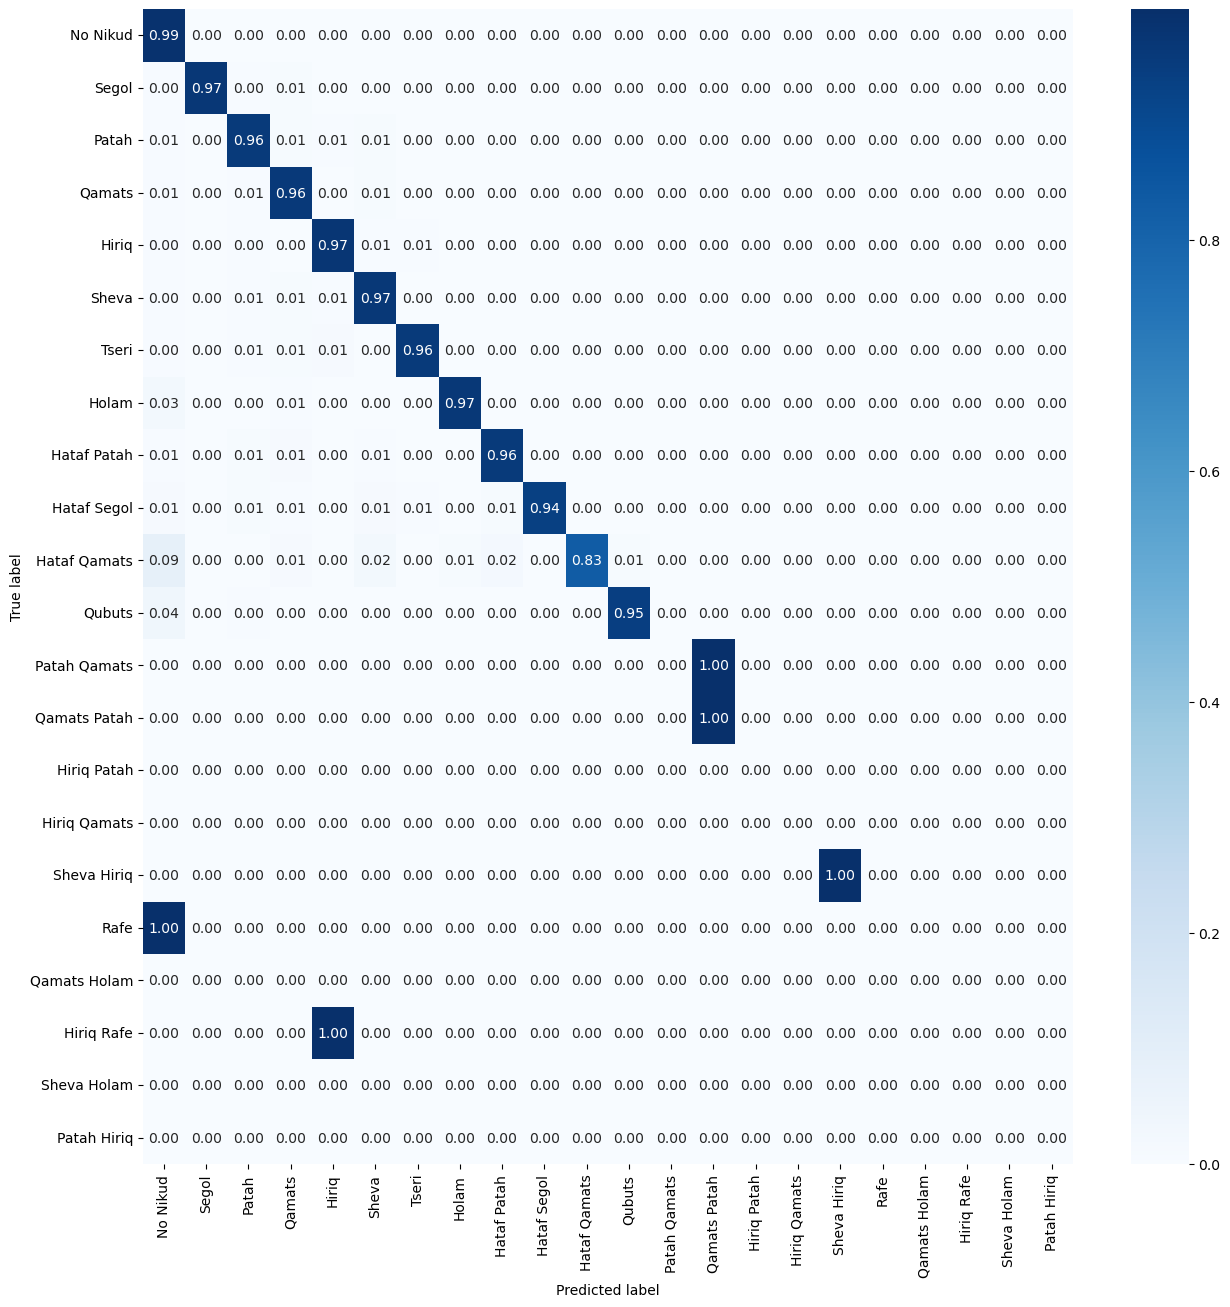

In [77]:
# get predictions for the test set
Full_sentence_actuals, Full_sentence_predictions, Full_sentence_word_lengths = predict_full_sentence_model(full_sentence_model, test_loader)
# convert the actual labels and the predictions to the original labels (not the ids)
Full_sentence_actuals = [id_to_label[label.item()] for label in Full_sentence_actuals]
Full_sentence_predictions = [id_to_label[label.item()] for label in Full_sentence_predictions]
# compute the accuracy
char_accuracy = compute_character_accuracy(Full_sentence_actuals, Full_sentence_predictions)
char_accuracy_without_no_nikud = compute_character_accuracy_without_no_nikud(Full_sentence_actuals, Full_sentence_predictions)
word_accuracy = compute_word_accuracy(Full_sentence_actuals, Full_sentence_predictions, Full_sentence_word_lengths)
word_accuracy_without_no_nikud = compute_word_accuracy_without_no_nikud(Full_sentence_actuals, Full_sentence_predictions, Full_sentence_word_lengths)
# print the results
print(f"Character-level accuracy: {char_accuracy:.2%}")
print(f"Character-level accuracy without no-nikud: {char_accuracy_without_no_nikud:.2%}")
print(f"Word-level accuracy: {word_accuracy:.2%}")
print(f"Word-level accuracy without no-nikud: {word_accuracy_without_no_nikud:.2%}")
# convert the labels to names
Full_sentence_actuals, Full_sentence_predictions, label_names = convert_labels_to_names(Full_sentence_actuals, Full_sentence_predictions, label_to_id)
# plot the confusion matrix
plot_confusion_matrix(Full_sentence_actuals, Full_sentence_predictions, list(label_names.values()))

## Analysis of Reading Direction Model

100%|██████████| 1902/1902 [08:01<00:00,  3.95it/s]


Character-level accuracy: 89.76%
Character-level accuracy without no-nikud: 84.30%
Word-level accuracy: 73.01%
Word-level accuracy without no-nikud: 76.20%


C:\Users\baruc\AppData\Local\Temp\ipykernel_22148\631582119.py:6: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


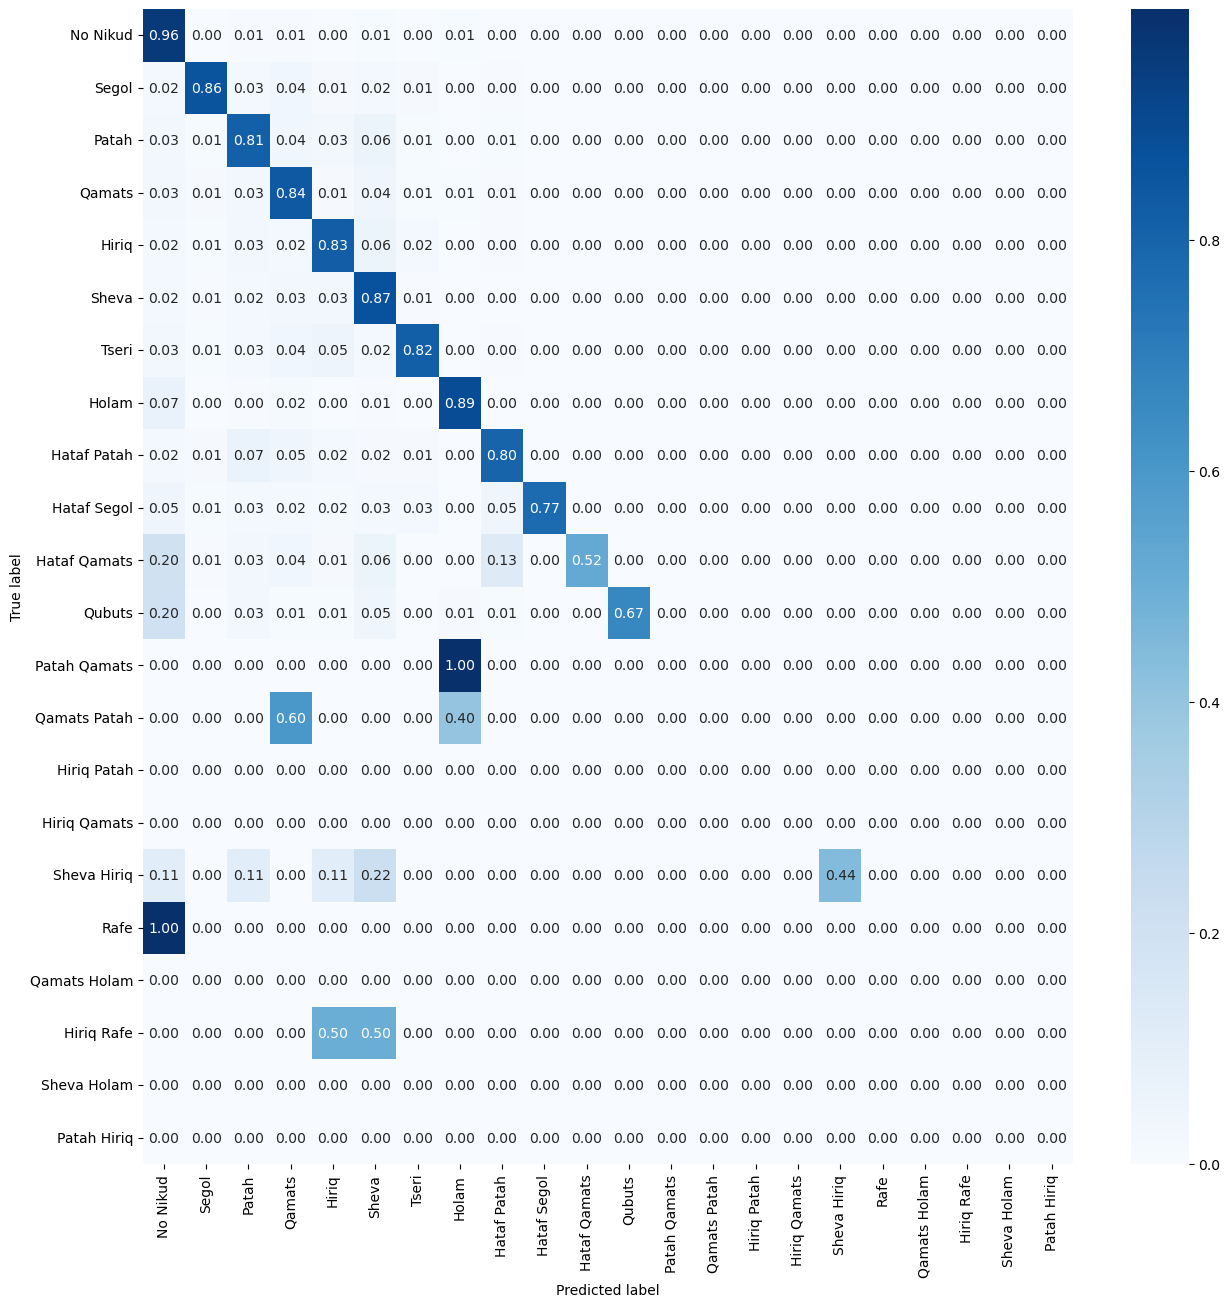

In [79]:
# get predictions for the test set
directional_actuals, directional_predictions, directional_word_lengths = predict_directional_model(reading_direction_model, test_loader)
# convert the actual labels and the predictions to the original labels (not the ids)
directional_actuals = [id_to_label[label.item()] for label in directional_actuals]
directional_predictions = [id_to_label[label.item()] for label in directional_predictions]
# compute the accuracy
char_accuracy = compute_character_accuracy(directional_actuals, directional_predictions)
char_accuracy_without_no_nikud = compute_character_accuracy_without_no_nikud(directional_actuals, directional_predictions)
word_accuracy = compute_word_accuracy(directional_actuals, directional_predictions, directional_word_lengths)
word_accuracy_without_no_nikud = compute_word_accuracy_without_no_nikud(directional_actuals, directional_predictions, directional_word_lengths)
# print the results
print(f"Character-level accuracy: {char_accuracy:.2%}")
print(f"Character-level accuracy without no-nikud: {char_accuracy_without_no_nikud:.2%}")
print(f"Word-level accuracy: {word_accuracy:.2%}")
print(f"Word-level accuracy without no-nikud: {word_accuracy_without_no_nikud:.2%}")
# convert the labels to names
directional_actuals, directional_predictions, label_names = convert_labels_to_names(directional_actuals, directional_predictions, label_to_id)
# plot the confusion matrix
plot_confusion_matrix(directional_actuals, directional_predictions, list(label_names.values()))

# Define the DuelModel class, it will be composed of two models.
#### whenever there is a disagreement between the two models, the model will add nikud using the lookahead model.
#### this way the DuelModel predicts ambiguous nikud.

In [83]:
class DuelModel():
    def __init__(self, full_sentence_model, directional_model, tokenizer, label_to_id, id_to_label):
        self.full_sentence_model = full_sentence_model
        self.directional_model = directional_model
        self.tokenizer = tokenizer
        self.id_to_label = id_to_label
        self.label_to_id = label_to_id
    
    def predict_batch(self, batch):
        """
        Predict the output using both models and combine their outputs.
        """
        # Set both models to evaluation mode
        self.full_sentence_model.eval()
        self.directional_model.eval()
        
        # Move the input data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        word_indices = batch['word_indices'].to(device)
        
        # Get the logits from both models
        with torch.no_grad():
            full_sentence_logits = self.full_sentence_model.forward(input_ids, word_indices)
            directional_logits = self.directional_model.forward(input_ids, word_indices)

        # Get the predictions from both models
        full_sentence_predictions = torch.argmax(full_sentence_logits, dim=2)
        directional_predictions = torch.argmax(directional_logits, dim=2)

        # Create a mask where predictions disagree
        disagreement_mask = full_sentence_predictions != directional_predictions
        
        # Initialize the combined predictions with zeros (no nikud)
        combined_predictions = torch.zeros_like(directional_predictions)
        
        # Use the full_sentence_model predictions where the two models disagree
        combined_predictions[disagreement_mask] = full_sentence_predictions[disagreement_mask]
        
        # Only select predictions where attention_mask is 1 (i.e., discard padding tokens)
        combined_predictions = [combined_predictions[i][attention_mask[i] == 1].tolist() for i in range(combined_predictions.size(0))]
        
        # Return the combined predictions and word lengths
        word_lengths = [word_indices[i][word_indices[i][:, 0] != -1].tolist() for i in range(word_indices.size(0))]
        word_lengths = [[y - x + 1 for x, y in sequence] for sequence in word_lengths]
        
        return combined_predictions, full_sentence_predictions, directional_predictions, word_lengths

    
    def decode_predictions(self, predictions):
        """ Convert numeric nikud predictions to strings """
        #return [[self.id_to_label[pred] for pred in sequence] for sequence in predictions]
        # like line abve, but if pred not in id_to_label, use 0 as key instead
        return [[self.id_to_label.get(pred, '<no_nikud>') for pred in sequence] for sequence in predictions]
    
    def encode_nikud(self, nikud_strings):
        """ Convert string nikud to their numeric form """
        return [[self.label_to_id[nik] for nik in sequence] for sequence in nikud_strings]
    
    def decode_tokens(self, input_ids):
        """ Convert token IDs back to words """
        return [self.tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids]
    
    # go over a given batch and print the results
    def display_detailed_prediction_stats(self, batch):
        combined_preds, full_preds, directional_preds, word_lengths = self.predict_batch(batch)
        nikud = batch['nikud'].to(device)
        
        for i, (comb_pred, full_pred, dir_pred) in enumerate(zip(combined_preds, full_preds, directional_preds)):
            print(f"\nPrediction {i}:")
            # print("Original nikud:\n", nikud[i].tolist())
            # print("Full sentence model predictions:\n", full_pred.tolist())
            # print("Directional model predictions:\n", dir_pred.tolist())
            # print("Combined predictions:\n", comb_pred)
            
            og_nikud_without_padding = batch['nikud'][i][batch['attention_mask'][i] == 1].to(device)
            full_pred_without_padding = full_pred[batch['attention_mask'][i] == 1].to(device)
            dir_pred_without_padding = dir_pred[batch['attention_mask'][i] == 1].to(device)
            pred_nikud = torch.tensor(comb_pred).to(device)
            relevant_attention_mask = batch['attention_mask'][i][:len(comb_pred)]
            pred_nikud_without_padding = pred_nikud[relevant_attention_mask == 1].to(device)


            print("Original nikud without padding:\n", og_nikud_without_padding.tolist())
            print("Full sentence model predictions without padding:\n", full_pred_without_padding.tolist())
            print("Directional model predictions without padding:\n", dir_pred_without_padding.tolist())
            print("Combined predictions without padding:\n", pred_nikud_without_padding.tolist())
            print("Word lengths: {}, in total: {}, nikud length without padding: {}".format(word_lengths[i], sum(word_lengths[i]), len(og_nikud_without_padding)))

            full_model_accuracy = (full_pred_without_padding == og_nikud_without_padding).sum().item() / (len(og_nikud_without_padding) + 1e-10)
            directional_model_accuracy = (dir_pred_without_padding == og_nikud_without_padding).sum().item() / (len(og_nikud_without_padding) + 1e-10)
            combined_model_accuracy = (pred_nikud_without_padding == og_nikud_without_padding).sum().item() / (len(og_nikud_without_padding) + 1e-10)

            print(f"Full sentence model accuracy: {full_model_accuracy}")
            print(f"Directional model accuracy: {directional_model_accuracy}")
            print(f"Combined model accuracy: {combined_model_accuracy}")

            full_model_accuracy_without_no_nikud = (full_pred_without_padding[og_nikud_without_padding != 0] == og_nikud_without_padding[og_nikud_without_padding != 0]).sum().item() / (len(og_nikud_without_padding[og_nikud_without_padding != 0]) + 1e-10)
            directional_model_accuracy_without_no_nikud = (dir_pred_without_padding[og_nikud_without_padding != 0] == og_nikud_without_padding[og_nikud_without_padding != 0]).sum().item() / (len(og_nikud_without_padding[og_nikud_without_padding != 0]) + 1e-10)
            combined_model_accuracy_without_no_nikud_og = (pred_nikud_without_padding[og_nikud_without_padding != 0] == og_nikud_without_padding[og_nikud_without_padding != 0]).sum().item() / (len(og_nikud_without_padding[og_nikud_without_padding != 0]) + 1e-10)
            combined_model_accuracy_without_no_nikud_combined = (pred_nikud_without_padding[pred_nikud_without_padding != 0] == og_nikud_without_padding[pred_nikud_without_padding != 0]).sum().item() / (len(pred_nikud_without_padding[pred_nikud_without_padding != 0]) + 1e-10)

            print(f"Full sentence model accuracy without no nikud in original: {full_model_accuracy_without_no_nikud}")
            print(f"Directional model accuracy without no nikud in original: {directional_model_accuracy_without_no_nikud}")
            print(f"Combined model accuracy without no nikud in original: {combined_model_accuracy_without_no_nikud_og}")
            print(f"Combined model accuracy without no nikud in combined: {combined_model_accuracy_without_no_nikud_combined}")

    # go over a given batch and print the results
    def display_readable_prediction_output(self, batch):
        # get the predictions
        combined_preds, full_sentence_predictions, directional_predictions, word_lengths = self.predict_batch(batch)

        # get the nikud from the batch and convert it to a list
        nikud = batch['nikud'].tolist()

        # convert numeric nikud to strings using the label_to_id dictionary
        decoded_nikud = self.decode_predictions(nikud)
        decoded_tokens = self.decode_tokens(batch['input_ids'])
        decoded_preds = self.decode_predictions(combined_preds)
        decoded_full_sentence_predictions = self.decode_predictions(full_sentence_predictions.tolist())
        decoded_directional_predictions = self.decode_predictions(directional_predictions.tolist())
        
        # iterate over the batch and print the results
        for i, (token, pred, nikud, full_pred, dir_pred, word_length) in enumerate(zip(decoded_tokens, decoded_preds, decoded_nikud, decoded_full_sentence_predictions, decoded_directional_predictions, word_lengths)):
            print(f"\nPrediction {i}:")
            # convert '<no_nikud>' to empty string
            nikud = [nikud if nikud != '<no_nikud>' else '' for nikud in nikud]
            pred = [nikud if nikud != '<no_nikud>' else '' for nikud in pred]
            full_pred = [nikud if nikud != '<no_nikud>' else '' for nikud in full_pred]
            dir_pred = [nikud if nikud != '<no_nikud>' else '' for nikud in dir_pred]
       

            # add nikud to token
            token_with_original_nikud = add_nikud_to_text(token, nikud, word_length)
            token_with_full_sentence_nikud = add_nikud_to_text(token, full_pred, word_length)
            token_with_directional_nikud = add_nikud_to_text(token, dir_pred, word_length)
            token_with_predicted_nikud = add_nikud_to_text(token, pred, word_length)

            # print the results
            print("Token with Original Nikud:")
            print(token_with_original_nikud)
            print("Token with Full Sentence Nikud")
            print(token_with_full_sentence_nikud)
            print("Token with Directional Nikud")
            print(token_with_directional_nikud)
            print("Token with Predicted Nikud")
            print(token_with_predicted_nikud)
            print("-" * 50)


# create the model and get a batch from the test loader for testing and displaying the results
duel_model = DuelModel(full_sentence_model, reading_direction_model, alephbert_tokenizer, label_to_id, id_to_label)
test_batch = next(iter(test_loader))

In [84]:
duel_model.display_detailed_prediction_stats(next_batch)


Prediction 0:
Original nikud without padding:
 [4, 5, 4, 0, 0, 1, 1, 0, 4, 0, 0, 7, 4, 0, 0, 5, 2, 8, 0, 7, 4, 0, 0]
Full sentence model predictions without padding:
 [2, 5, 4, 0, 0, 1, 1, 0, 4, 0, 0, 7, 4, 0, 0, 5, 2, 8, 0, 7, 4, 0, 0]
Directional model predictions without padding:
 [2, 5, 6, 0, 0, 1, 1, 0, 4, 0, 0, 7, 4, 0, 0, 5, 2, 8, 0, 7, 4, 0, 0]
Combined predictions without padding:
 [0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Word lengths: [5, 3, 7, 8], in total: 23, nikud length without padding: 23
Full sentence model accuracy: 0.956521739126276
Directional model accuracy: 0.9130434782568999
Combined model accuracy: 0.478260869563138
Full sentence model accuracy without no nikud in original: 0.9230769230698225
Directional model accuracy without no nikud in original: 0.8461538461473372
Combined model accuracy without no nikud in original: 0.0769230769224852
Combined model accuracy without no nikud in combined: 0.9999999999

Prediction 1:
Original niku

In [85]:
duel_model.display_readable_prediction_output(next_batch)



Prediction 0:
Token with Original Nikud:
מִתְרִיס נֶגֶד רִאשוֹנִים וְאַחֲרוֹנִים 
Token with Full Sentence Nikud
מַתְרִיס נֶגֶד רִאשוֹנִים וְאַחֲרוֹנִים 
Token with Directional Nikud
מַתְרֵיס נֶגֶד רִאשוֹנִים וְאַחֲרוֹנִים 
Token with Predicted Nikud
מתרִיס נגד ראשונים ואחרונים 
--------------------------------------------------

Prediction 1:
Token with Original Nikud:
הֲרֵי הִיא עֲדַיִין בְחֶזְקַת אא 
Token with Full Sentence Nikud
הֲרֵי הִיא עֲדַיִין בְחֶזְקַת אא 
Token with Directional Nikud
הֲרֵי הִיא עֲדַיִין בְחֶזְקַת אא 
Token with Predicted Nikud
הרי היא עדיין בחזקת אא 
--------------------------------------------------

Prediction 2:
Token with Original Nikud:
וריבז הָיָה נָשִיא אַחַכ וְהָיָה מִקְטַנֵי תַלְמִידָיו שֶל הִלֵל כִדְאִיתָא בְסֻוכָה שָם ור צָדוֹק שֶהֵיקֵל לֶאֱכֹול פָחוֹת מִכַבֵיצָה חוץ לַסֻוכָה יל דסל 
Token with Full Sentence Nikud
וְריבז הָיָה נָשִיא אַחַכ וְהָיָה מִקְטַנֵי תַלְמִידָיו שֶל הלל כִדְאִיתָא בְסֻוכָה שָם ור צָדוק שֶהֵיקֵל לֶאֱכֹול פָחוֹת מִכַבֵיצָה 